## Imports

In [2]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

import sys
sys.path.insert(1, './../src/')

import time 

import load_option_data_01 

from pathlib import Path

import bsm_pricer as bsm
import config
import datetime
import filter_option_data_01 as f1
import filter_option_data_02 as f2
import filter_option_data_03 as f3
import load_option_data_01 
import load_option_data_01 as l1


import time 
import warnings
import wrds

In [3]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
warnings.filterwarnings("ignore")

In [4]:
OUTPUT_DIR = Path(config.OUTPUT_DIR)
DATA_DIR = Path(config.DATA_DIR)
WRDS_USERNAME = config.WRDS_USERNAME

START_DATE_01 =config.START_DATE_01
END_DATE_01 = config.END_DATE_01

START_DATE_02 =config.START_DATE_02
END_DATE_02 = config.END_DATE_02

NOTE_START = START_DATE_01
NOTE_END = END_DATE_01

## Function Definitions

In [5]:
def fit_and_store_curve(group):
    """
    Fit a quadratic curve to the given group of data points and store the fitted values.

    Args:
        group (pandas.DataFrame): The group of data points to fit the curve to.

    Returns:
        pandas.DataFrame: The group of data points with the fitted values stored in the 'fitted_iv' column.
    """
    try:
        # Fit the quadratic curve
        coefficients = np.polyfit(group['mnyns'], group['log_iv'], 2)
        # Calculate fitted values
        group['fitted_iv'] = np.polyval(coefficients, group['mnyns'])
    except np.RankWarning:
        print("Polyfit may be poorly conditioned")
    return group

In [6]:
def calc_relative_distance(series1, series2, method='percent'):
    """
    Calculate the relative distance between the implied volatility and the fitted implied volatility.
    
    Parameters:
        method (str): The method to calculate the relative distance. Options are 'percent', 'manhattan', or 'euclidean'.
        
    Returns:
        numpy.ndarray: The relative distance calculated based on the specified method.
        
    Raises:
        ValueError: If the method is not one of 'percent', 'manhattan', or 'euclidean'.
    """
    
    if method == 'percent':
        result = (series1 - series2) / series2 * 100
    elif method == 'manhattan':
        result = abs(series1 - series2)
    elif method == 'euclidean':
        result = np.sqrt((series1 - series2)**2)
    else:
        raise ValueError("Method must be 'percent', 'manhattan', or 'euclidean'")
    
    result = np.where(np.isinf(result), np.nan, result)
    
    return result

In [7]:
def mark_outliers(row, std_devs, outlier_threshold):
    """
    Determines if a data point is an outlier based on its moneyness_bin and relative distance from the fitted curve.
    
    Args:
        row (pandas.Series): A row of data containing the moneyness_bin and rel_distance columns.
        std_devs (pandas.DataFrame): A DataFrame containing the standard deviations for each moneyness_bin.
    
    Returns:
        bool: True if the data point is an outlier, False otherwise.
    """
    
    # Attempt to retrieve the standard deviation for the row's moneyness_bin
# This operation may be vectorizable if repeated across rows
    std_dev_row = std_devs.loc[std_devs['mnyns_bin'] == row['mnyns_bin'], 'std_dev']
    
    # Check if std_dev_row is empty (i.e., no matching moneyness_bin was found)
    if not std_dev_row.empty:
        std_dev = std_dev_row.values[0]
        # Calculate how many std_devs away from the fitted curve the IV is
        if abs(row['rel_distance']) > outlier_threshold * std_dev:  # Adjust this threshold as needed
            return True
    else:
        # Handle the case where no matching moneyness_bin was found
        return False
    return False


def build_put_call_pairs(call_options, put_options):
    """
    Builds pairs of call and put options based on the same date, expiration date, and moneyness.

    Args:
        call_options (DataFrame): DataFrame containing call options data.
        put_options (DataFrame): DataFrame containing put options data.

    Returns:
        tuple of (matching_calls: pd.DataFrame, matching_puts: pd.DataFrame)
    """
    call_options.set_index(['date', 'exdate', 'mnyns'], inplace=True)
    put_options.set_index(['date', 'exdate', 'mnyns'], inplace=True)
    
    # get common indices
    common_index = call_options.index.intersection(put_options.index)

    # Extract the matching entries
    matching_calls = call_options.loc[common_index]
    matching_puts = put_options.loc[common_index]
    
    result = (matching_calls, matching_puts)

    return result


def test_price_strike_match(matching_calls_puts):
    """
    Check if the strike prices and security prices of matching calls and puts are equal.

    Parameters:
    matching_calls_puts (DataFrame): DataFrame containing matching calls and puts data.

    Returns:
    bool: True if the strike prices and security prices of matching calls and puts are equal, False otherwise.
    """
    return (np.allclose(matching_calls_puts['strike_price_C'], matching_calls_puts['strike_price_P'])) and (np.allclose(matching_calls_puts['sec_price_C'], matching_calls_puts['sec_price_P']))# and (np.allclose(matching_calls_puts['tb_m3_C'], matching_calls_puts['tb_m3_P']))


def calc_implied_interest_rate(matched_options):
    """
    Calculates the implied interest rate based on the given matched options data.

    Parameters:
    matched_options (DataFrame): DataFrame containing the matched options data.

    Returns:
    DataFrame: DataFrame with an additional column 'pc_parity_int_rate' representing the implied interest rate.
    
    Raises:
    ValueError: If there is a mismatch between the price and strike price of the options.
    """
    
    # underlying price
    if test_price_strike_match(matched_options):
        print(">> Underlying prices, strike prices of put and call options match exactly.")
        S = matched_options['sec_price_C']
        K = matched_options['strike_price_C']  
        
        # 1/T = 1/time to expiration in years
        T_inv = np.power((matched_options.reset_index()['exdate']-matched_options.reset_index()['date'])/datetime.timedelta(days=365), -1)
        T_inv.index=matched_options.index
        T_inv
        
        C_mid = matched_options['mid_price_C']
        P_mid = matched_options['mid_price_P']
        # implied interest rate
        matched_options['pc_parity_int_rate'] = np.log((S-C_mid+P_mid)/K) * T_inv
        return matched_options
    else:
        raise ValueError("Price and strike price mismatch")


def pcp_filter_outliers(matched_options, int_rate_rel_distance_func, outlier_threshold):
    """
    Filters out outliers based on the relative distance of interest rates and the outlier threshold.

    Parameters:
    - matched_options (DataFrame): DataFrame containing the matched options data.
    - int_rate_rel_distance_func (str): Method to calculate the relative distance of interest rates.
    - outlier_threshold (float): Threshold for flagging outliers.

    Returns:
    - l3_filtered_options (DataFrame): DataFrame with outliers filtered out.

    """

    matched_options['rel_distance_int_rate'] = calc_relative_distance(matched_options['pc_parity_int_rate'], matched_options['daily_median_rate'], method=int_rate_rel_distance_func)
    # fill 3905 nans...
    matched_options['rel_distance_int_rate'] = matched_options['rel_distance_int_rate'].fillna(0.0)

    # calculate the standard deviation of the relative distances
    stdev_int_rate_rel_distance = matched_options['rel_distance_int_rate'].std()

    # flag outliers based on the threshold
    matched_options['is_outlier_int_rate'] = matched_options['rel_distance_int_rate'].abs() > outlier_threshold * stdev_int_rate_rel_distance

    # filter out the outliers
    l3_filtered_options = matched_options[~matched_options['is_outlier_int_rate']]

    # make the dataframe long-form to compare to the level 2 data
    _calls = l3_filtered_options.filter(like='_C').rename(columns=lambda x: x.replace('_C', ''))
    _puts = l3_filtered_options.filter(like='_P').rename(columns=lambda x: x.replace('_P', ''))
    l3_filtered_options = pd.concat((_calls, _puts), axis=0)

    # update the final results for this combination of relative distance method and outlier threshold
    return l3_filtered_options


def iv_filter_outliers(l2_data, iv_distance_method, iv_outlier_threshold):
    """
    Filter out outliers based on the relative distance of log_iv and fitted_iv.

    Parameters:
    l2_data (DataFrame): Input data containing log_iv, fitted_iv, mnyns columns.
    iv_distance_method (str): Method to calculate relative distance of log_iv and fitted_iv.
    iv_outlier_threshold (float): Threshold value to flag outliers.

    Returns:
    DataFrame: Filtered data without outliers.

    """
    l2_data['rel_distance_iv'] = calc_relative_distance(l2_data['log_iv'], l2_data['fitted_iv'], method=iv_distance_method)

    # Define moneyness bins
    bins = np.arange(0.8, 1.21, 0.05)
    l2_data['mnyns_bin'] = pd.cut(l2_data['mnyns'], bins=bins)

    # Compute standard deviation of relative distances within each moneyness bin
    std_devs = l2_data.groupby('mnyns_bin')['rel_distance_iv'].std().reset_index(name='std_dev')
    
    l2_data['stdev_iv_mnyns_bin'] = l2_data['mnyns_bin'].map(std_devs.set_index('mnyns_bin')['std_dev'])
    l2_data['stdev_iv_mnyns_bin'].apply(lambda x: x*iv_outlier_threshold).astype(float)
    # flag outliers based on the threshold
    l2_data['is_outlier_iv'] = l2_data['rel_distance_iv'].abs() > l2_data['stdev_iv_mnyns_bin'].apply(lambda x: x*iv_outlier_threshold).astype(float)

    # filter out the outliers
    l3_data_iv_only = l2_data[~l2_data['is_outlier_iv']]
    
    # update the final results for this combination of relative distance method and outlier threshold
    return l3_data_iv_only

## Data Note

- The original CJS 2013 paper used data from 1986 through 2012 (26 years of data).
- Due to the unavailability of SPX option data from 1985 to 1995, we replicated the **54 CJS portfolios** using data from **January 1996 to December 2019** (23 years).
- Our dataset (from 1996 to 2019) comprises over 19.2 million rows of SPX options data.
- The original effectiveness of the data filters was examined in *The Puzzle of Filtering Index Options (Desai, Hammock, Holt; 2024)*. Due to similar reasons as outlined in that work (loss of data filter elegance when transposed across timeframes), we expect that the data filter parameters (and thus the portfolios constructed) will not yield identical results to the original published work, and the user should not have this expectation. 

*The spirit of this project is to replicate with the highest practical fidelity the *process* of data filtration and portfolio construction in the original CJS and HKM papers, without commenting on the effectiveness or appropriateness of the process and parameters. We leave that analysis to a future study.*

In [19]:
file_path = Path(DATA_DIR / 'pulled/data_1996-01_2019-12.parquet')

if file_path.exists():
    print(">> File already exists. Loading data from file...")
    # Load the data from the file
    raw_option_data = pd.read_parquet(file_path)
else:
    print(">> File does not exist. Loading data from WRDS...")
    # Load the data from WRDS
    raw_option_data = pd.concat([
        pd.read_parquet(Path(DATA_DIR / 'pulled/data_1996-01_2012-01.parquet')),
        pd.read_parquet(Path(DATA_DIR / 'pulled/data_2012-02_2019-12.parquet'))
    ])
    raw_option_data.to_parquet(file_path)


raw_option_data

>> File already exists. Loading data from file...


,secid,date,open,close,cp_flag,exdate,impl_volatility,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.000,56.000,565000.0,100.0
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.500,76.500,540000.0,100.0
2,108105.0,1996-01-05,617.70,616.71,C,1996-02-17,NaN,5.03,500.0,5900.0,57.750,58.750,560000.0,100.0
3,108105.0,1996-01-08,616.71,618.46,C,1996-03-16,NaN,5.03,0.0,315.0,145.500,146.500,475000.0,100.0
4,108105.0,1996-01-09,618.46,609.45,C,1996-12-21,NaN,5.01,0.0,8.0,188.375,189.375,425000.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66102,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,944.700,962.900,4200000.0,100.0
66103,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1042.000,1060.300,4300000.0,100.0
66104,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1140.000,1158.200,4400000.0,100.0
66105,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1237.900,1256.100,4500000.0,100.0


# 1. Data Filtration

In order to minimize possible quoting errors, CJS filtered the raw options data through 3 levels of filters. The filters are applied to the trade-in (buy) side to make sure the portfolios are buying into reliable quotes. When positions are exited, if there is no quote in the filtered data, the raw data is searched. These filters are detailed in *Appendix B* of CJS. 

## Level 1 Filters

* **Identical Filter:** Retain only one instance of quotes with the same **option type**, **strike price**, **expiration date/maturity**, and **price**. 

* **Identical Except Price Filter:** There are a few sets of quotes with identical terms (**type**, **strike**, and **maturity**) but different prices. Keep the quote whose **T-bill-based implied volatility** is closest to that of its **moneyness neighbors**, and delete the others.  

* **Bid = 0 Filter:** Drop quotes with a **bid price** of zero, thereby avoiding low-valued options. Also, a zero bid may indicate censoring as negative bids cannot be recorded.

* **Volume = 0 Filter:** Drop quotes of zero for volumes. *Note: Appendix B of CJS does not explicitly detail this filter, but we include it here since it is included in *Table B.1. Filters* of CJS.*  



In [ ]:
# add the mid price
raw_option_data['mid_price'] = (raw_option_data['best_bid'] + raw_option_data['best_offer']) / 2
# adjust strike price 
raw_option_data['strike_price'] /= 1000


In [50]:
optm_l1_load = raw_option_data.copy()
optm_l1_load = f1.calc_moneyness(optm_l1_load)

In [51]:
optm_l1_load

,secid,date,open,close,cp_flag,exdate,impl_volatility,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,mid_price,moneyness
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.000,56.000,565.0,100.0,55.500,0.914684
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.500,76.500,540.0,100.0,76.000,0.874211
2,108105.0,1996-01-05,617.70,616.71,C,1996-02-17,NaN,5.03,500.0,5900.0,57.750,58.750,560.0,100.0,58.250,0.908044
3,108105.0,1996-01-08,616.71,618.46,C,1996-03-16,NaN,5.03,0.0,315.0,145.500,146.500,475.0,100.0,146.000,0.768037
4,108105.0,1996-01-09,618.46,609.45,C,1996-12-21,NaN,5.01,0.0,8.0,188.375,189.375,425.0,100.0,188.875,0.697350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66102,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,944.700,962.900,4200.0,100.0,953.800,1.299996
66103,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1042.000,1060.300,4300.0,100.0,1051.150,1.330948
66104,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1140.000,1158.200,4400.0,100.0,1149.100,1.361900
66105,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1237.900,1256.100,4500.0,100.0,1247.000,1.392853


## Plot Loaded Data

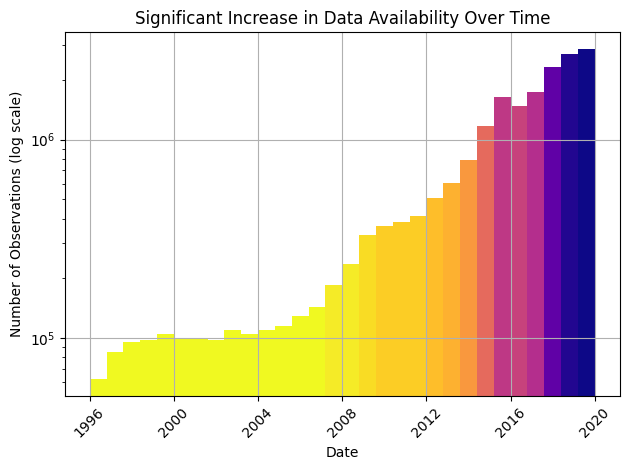

In [10]:
# Histogram parameters
counts, bins, patches = plt.hist(optm_l1_load['date'], bins=30)

# Apply magma colormap
cmap = cm.get_cmap('plasma_r', len(patches))
normed = (counts - counts.min()) / (counts.max() - counts.min())
for patch, norm in zip(patches, normed):
    patch.set_facecolor(cmap(norm))

# Labels and aesthetics
plt.xlabel('Date')
plt.yscale('log')
plt.grid()
plt.ylabel('Number of Observations (log scale)')
plt.title('Significant Increase in Data Availability Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

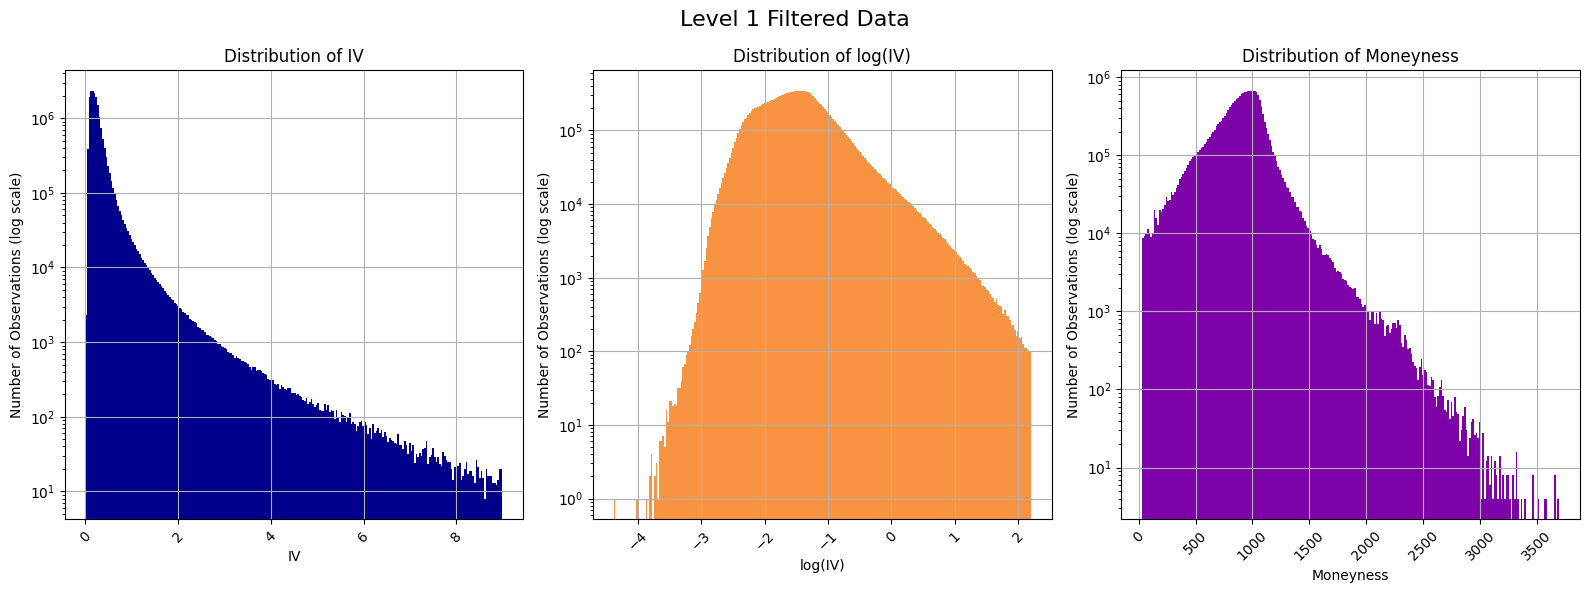

In [11]:
# Prepare data
datplot = optm_l1_load.copy()
datplot['log_iv'] = np.log(datplot['impl_volatility'])

# Custom colors from plasma_r
cmap = cm.get_cmap('plasma_r')
colors = ['darkblue', cmap(0.25), cmap(0.75)]

# Plot setup
fig, ax = plt.subplots(1, 3, figsize=(16, 6))
axes = ax.flatten()

variables = ['impl_volatility', 'log_iv', 'mnyns']
titles = ['Distribution of IV', 'Distribution of log(IV)', 'Distribution of Moneyness']
xlabels = ['IV', 'log(IV)', 'Moneyness']

for i, var in enumerate(variables):
    axes[i].hist(datplot[var], bins=250, color=colors[i])
    axes[i].set_xlabel(xlabels[i])
    axes[i].set_ylabel('Number of Observations (log scale)')
    axes[i].set_title(titles[i])
    axes[i].set_yscale('log')
    axes[i].grid(True)
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Level 1 Filtered Data', fontsize=16)
plt.tight_layout()
plt.show()

## Filter Duplicates

We drop records with identical **option type, strike, expiration date, and price**. In each such case, we eliminate all but one of the quotes. 

In [ ]:
unique_key_fields = ['cp_flag', 'strike_price', 'exdate', 'mid_price']
optm_l1_load['unique_key'] = optm_l1_load[unique_key_fields].astype(str).agg('-'.join, axis=1)
optm_l1_load['unique_key'] = optm_l1_load['unique_key'].str.replace(' ', '-')
optm_l1_load['unique_key'] = optm_l1_load['unique_key'].str.replace(':', '-')
optm_l1_load

In [29]:
optm_l1_load

,secid,date,open,close,cp_flag,exdate,impl_volatility,tb_m3,volume,open_interest,best_bid,best_offer,strike_price,contract_size,sec_price,mnyns,mid_price
0,108105.0,1996-01-04,621.32,617.70,C,1996-03-16,NaN,5.04,0.0,1704.0,55.000,56.000,565000.0,100.0,617.70,914.683503,55.500
1,108105.0,1996-01-04,621.32,617.70,C,1996-01-20,NaN,5.04,0.0,108.0,75.500,76.500,540000.0,100.0,617.70,874.210782,76.000
2,108105.0,1996-01-05,617.70,616.71,C,1996-02-17,NaN,5.03,500.0,5900.0,57.750,58.750,560000.0,100.0,616.71,908.044300,58.250
3,108105.0,1996-01-08,616.71,618.46,C,1996-03-16,NaN,5.03,0.0,315.0,145.500,146.500,475000.0,100.0,618.46,768.036736,146.000
4,108105.0,1996-01-09,618.46,609.45,C,1996-12-21,NaN,5.01,0.0,8.0,188.375,189.375,425000.0,100.0,609.45,697.350070,188.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66102,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,944.700,962.900,4200000.0,100.0,3230.78,1299.995667,953.800
66103,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1042.000,1060.300,4300000.0,100.0,3230.78,1330.947944,1051.150
66104,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1140.000,1158.200,4400000.0,100.0,3230.78,1361.900222,1149.100
66105,108105.0,2019-12-31,3215.18,3230.78,P,2020-12-31,NaN,1.52,0.0,0.0,1237.900,1256.100,4500000.0,100.0,3230.78,1392.852500,1247.000


In [13]:
optm_l1_load.shape

(19213898, 16)

In [14]:
optm_l1_id = f1.delete_identical_filter(optm_l1_load)
optm_l1_load['mid_price']= (optm_l1_load['best_bid'] + optm_l1_load['best_offer'])/2

In [15]:
optm_l1_load.shape

(19213898, 17)

In [21]:
print(f'About {optm_l1_id.impl_volatility.isna().sum()/ optm_l1_id.shape[0]:,.2%} of the data is missing IV values in the original data set.')

About 10.96% of the data is missing IV values in the original data set.


## Filter Identical in all but price

The OptionMetrics data set contain duplicate observations,
defined as two or more quotes with identical option type, strike, expiration
date, and price. In each such case, we eliminate all but one of the quotes.

In [1]:
optm_l1_id

NameError: name 'optm_l1_id' is not defined

In [25]:
optm_l1_idxp = f1.delete_identical_but_price_filter(optm_l1_load)

In [26]:
optm_l1_idxp.shape

(16102364, 17)

In [23]:
optm_l1_idxp.shape == optm_l1_id.shape

False

In [ ]:
duplicate_counts = optm_l1_id.groupby(['date', 'cp_flag', 'strike_price', 'exdate']).size().reset_index(name='count')
duplicate_counts = duplicate_counts.loc[duplicate_counts['count'] > 1]

fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x='date', y='count', hue='cp_flag', data=duplicate_counts)
ax.set_xlabel('date')
ax.set_ylabel('count')
ax.set_title('Distribution of Duplicate Observations - Identical Terms Except Price')
plt.show()

## Filter Options with Bid = 0 

We remove quotes of zero for bids, thereby avoiding low-valued options. Also, a zero bid may indicate censoring as negative bids
cannot be recorded.

In [ ]:
optm_l1_zbid = f1.delete_zero_bid_filter(optm_l1_id)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot distribution of best_bid for optm_l1_id
axes[0].hist(optm_l1_id['best_bid'], bins=30)
axes[0].set_xlabel('Best Bid')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Best Bid - Pre-filter')

# Plot distribution of best_bid for optm_l1_zbid
axes[1].hist(optm_l1_zbid['best_bid'], bins=30, color='darkred')
axes[1].set_xlabel('Best Bid')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Best Bid - Post-filter')

plt.tight_layout()
plt.show()

## Filter Options with Vol = 0

In Table B.1 the paper includes a filter to exclude options where the volume is zero. Based on the table, after applying the filter the number of options deleted is zero. From our analysis, there are over 2 million rows with a volume of zero. As a result, we decided to not apply this filter to avoid dramatically skewing our results away from the original table.

In [ ]:
optm_l1_zvol = f1.delete_zero_volume_filter(optm_l1_zbid)

In [ ]:
zero_vol_rows = optm_l1_zbid[optm_l1_zbid['volume'] == 0]
plt.hist(zero_vol_rows['date'], bins=30)
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Distribution of Options with Zero Volume')
plt.show()

## Summarize Level 1 Filters

After application of the level 1 filters, quotes with zero bids was the primary driver of deleted observations.

In [ ]:
df2, df2_sum, df2_B1 = f1.appendixBfilter_level1(optm_l1_load)
df2_B1 = df2_B1.reset_index().rename(columns={'index': 'Substep'}).set_index(['Step', 'Substep']).map('{:,.0f}'.format)
df2_B1 = df2_B1.map(lambda x: '' if str(x).lower() == 'nan' else x)
df2_B1

# Appendix B: Level 2 Filters

#### After applying the first level of filters, we continue with the four "level 2" filters detailed below:

* `“Days to Maturity <7 or >180” Filter:` We remove all options with fewer than
seven or more than 180 calendar days to expiration. The short maturity options tend to move erratically close to expiration and the long maturity options lack volume and open interest.
“IV<5% or >100%” Filter: We remove all option quotes with implied volatilities lower than 5% or higher than 100%, computed using T-bill interest
rates. Such extreme values likely indicate quotation problems or simply low
value.

* `“Moneyness <0.8 or >1.2” Filter:` We remove all option quotes with moneyness, the ratio of strike price to index price, below 0.8 or above 1.2. These
options have little value beyond their intrinsic value and are also very thinly
traded.

* `“Implied Interest Rate <0” Filter:` When filtering outliers, we use T-bill interest rates to compute implied volatilities. T-bill interest rates are obtained from
the Federal Reserve’s H.15 release. We assign a T-bill rate to each observation
by assuming that we can use the next shortest rate if the time to expiration of
the option is shorter than the shortest constant maturity rate.
Our goal is to obtain an interest rate that is as close as possible to the one
faced by investors in the options market. It appears that the T-bill rates are
not the relevant ones when pricing these options. Specifically, when the T-bill
rates are used, put and call implied volatilities do not line up very well; for
example, the T-bill rate tends to be too high for short maturity options, perhaps because no T-bill has maturity of less than a month. To address these
issues, we compute a put-call parity-implied interest rate. Since we believe that
put-call parity holds reasonably well in this deep and liquid European options
market, we use the put-call parity-implied interest rate as our interest rate in
the remainder of the paper and for further filters.
To construct this rate, we take all put-call pairs of a given maturity and
impose put-call parity using the bid-ask midpoint as the price, and allowing
the interest rate to adjust. We remove 89,563 pairs with a negative implied
interest rate. We then take the median-implied interest rate across all remaining pairs of the same maturity with moneyness between 0.95 and 1.05 and
assign it to all quotes with that maturity. We are able to directly assign an
implied interest rate to 93% of our sample in this way. We fill in the gaps by
interpolating across maturities and if necessary, across days. Our implied
interest rate is on average 54 bps above the T-bill rate

* `“Unable to Compute IV” Filter:` We remove quotes that imply negative time
value.


In [ ]:
START_DATE_01 =config.START_DATE_01
END_DATE_01 = config.END_DATE_01

In [ ]:
# load data with level 1 filters applied
optm_l1_df = pd.read_parquet(DATA_DIR / "intermediate" / "data_1996-01_2012-01_L1filter.parquet")

## “Days to Maturity <7 or >180” Filter

In [ ]:
# calculate time to maturity in years for level 1 data
optm_l1_df['time_to_maturity_yrs'] = f2.calc_time_to_maturity_yrs(optm_l1_df)

# create data frame with initial level 2 filter for time to maturity applied
optm_l2_df = f2.filter_time_to_maturity(optm_l1_df)

#### Distribution of time to maturity, measured in years from option initial date to expiration date. Left shows the distribution prior to applying the initial level 2 filter of excluding days to maturity less than 7 and greater than 180. Right shows distribution post filter. 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting histogram for optm_l1_df
axes[0].hist(optm_l1_df['time_to_maturity_yrs'], bins=10, edgecolor='black')
axes[0].set_xlabel('Time to Maturity (Years)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Time to Maturity (Pre-Filter)')

# Plotting histogram for optm_l2_df
axes[1].hist(optm_l2_df['time_to_maturity_yrs'], bins=10, edgecolor='black', color='darkred')
axes[1].set_xlabel('Time to Maturity (Years)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Time to Maturity (Post-Filter)')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### As noted in the paper, the short maturity options tend to move erratically close to expiration. In the graph below, post filter we see a slight reduction of short term options with a high implied volatility.

In [ ]:
sample_size = 200000  # Adjust as needed
sample_ind_l1 = random.sample(range(len(optm_l1_df)), min(sample_size, len(optm_l1_df)))
sample_ind_l2 = random.sample(range(len(optm_l2_df)), min(sample_size, len(optm_l2_df)))

plt.plot(optm_l1_df.iloc[sample_ind_l1]['time_to_maturity_yrs'], optm_l1_df.iloc[sample_ind_l1]['impl_volatility'], 'o', alpha=0.5, label='Pre-Filter')
plt.plot(optm_l2_df.iloc[sample_ind_l2]['time_to_maturity_yrs'], optm_l2_df.iloc[sample_ind_l2]['impl_volatility'], 'o', alpha=0.5, label='Post-Filter', color='darkred')
plt.xlabel('Time to Maturity (Years)')
plt.ylabel('Implied Volatility')
plt.title('Implied Volatility vs Time to Maturity (Random Sample)')
plt.legend()
plt.show()

#### Also noted in the paper, the long maturity options lack volume and open interest. On the right (in red), the filter has a smoothing affect on the distribution of volumn and open interest.

In [ ]:
vol_ttm_1 = optm_l1_df.groupby('time_to_maturity')['volume'].sum().reset_index()
vol_ttm_2 = optm_l2_df.groupby('time_to_maturity')['volume'].sum().reset_index()
int_ttm_1 = optm_l1_df.groupby('time_to_maturity')['open_interest'].sum().reset_index()
int_ttm_2 = optm_l2_df.groupby('time_to_maturity')['open_interest'].sum().reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting volume for optm_l1_df as a bar graph
axes[0].bar(vol_ttm_1['time_to_maturity'], vol_ttm_1['volume'], alpha=0.7)
axes[0].set_xlabel('Time to Maturity (Years)')
axes[0].set_ylabel('Volume')
axes[0].set_title('Volume vs Time to Maturity (Pre-Filter)')

# Plotting volume for optm_l2_df as a bar graph
axes[1].bar(vol_ttm_2['time_to_maturity'], vol_ttm_2['volume'], color='darkred', alpha=0.7)
axes[1].set_xlabel('Time to Maturity (Years)')
axes[1].set_ylabel('Volume')
axes[1].set_title('Volume vs Time to Maturity (Post-Filter)')

# Rotating x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plotting volume for optm_l1_df as a bar graph
axes[0].bar(int_ttm_1['time_to_maturity'], int_ttm_1['open_interest'], alpha=0.7)
axes[0].set_xlabel('Time to Maturity (Years)')
axes[0].set_ylabel('Open Interest')
axes[0].set_title('Open Interest vs Time to Maturity (Pre-Filter)')

# Plotting volume for optm_l2_df as a bar graph
axes[1].bar(int_ttm_2['time_to_maturity'], int_ttm_2['open_interest'], color='darkred', alpha=0.7)
axes[1].set_xlabel('Time to Maturity (Years)')
axes[1].set_ylabel('Open Interest')
axes[1].set_title('Open Interest vs Time to Maturity (Post-Filter)')

# Rotating x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## “IV<5% or >100%” Filter

In [ ]:
optm_l2_iv = f2.filter_iv(optm_l2_df)

#### As shown below removing option quotes w/ implied volatilities lower than 5% or higher than 100% removes extreme values and reduces the skewness of the implied volatility distribution.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting histogram for optm_l2_df
axes[0].hist(optm_l2_df['impl_volatility'], bins=10, edgecolor='black')
axes[0].set_xlabel('Implied Volatility')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Implied Volatility (Pre-Filter)')

# Plotting histogram for optm_l1_iv
axes[1].hist(optm_l2_iv['impl_volatility'], bins=10, edgecolor='black', color='darkred')
axes[1].set_xlabel('Implied Volatility')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Implied Volatility (Post-Filter)')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sample_size = 200000  # Adjust as needed
sample_ind_iv = random.sample(range(len(optm_l2_iv)), min(sample_size, len(optm_l2_iv)))
sample_ind = random.sample(range(len(optm_l2_df)), min(sample_size, len(optm_l2_df)))


# Plotting optm_l2_df
axes[0].scatter(optm_l2_df.iloc[sample_ind]['best_bid'], optm_l2_df.iloc[sample_ind]['impl_volatility'])
axes[0].set_xlabel('Best Bid')
axes[0].set_ylabel('Implied Volatility')
axes[0].set_title('Implied Volatility vs Best Bid (Pre-Filter)')

# Plotting optm_l2_iv
axes[1].scatter(optm_l2_iv.iloc[sample_ind_iv]['best_bid'], optm_l2_iv.iloc[sample_ind_iv]['impl_volatility'])
axes[1].set_xlabel('Best Bid')
axes[1].set_ylabel('Implied Volatility')
axes[1].set_title('Implied Volatility vs Best Bid (Post-Filter)')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

## “Moneyness <0.8 or >1.2” Filter

In [ ]:
optm_l2_mny = f2.filter_moneyness(optm_l2_iv)

#### Removing option quotes with moneyness lower than 0.8 and higher than 1.2 eliminates extreme values. These extreme values potentially have quotation problems or low values. 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting histogram for optm_l2_iv
axes[0].hist(optm_l2_iv['mnyns'], bins=10, edgecolor='black')
axes[0].set_xlabel('Moneyness')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of Moneyness (Pre-Filter)')

# Plotting histogram for optm_l2_mny
axes[1].hist(optm_l2_mny['mnyns'], bins=10, edgecolor='black', color='darkred')
axes[1].set_xlabel('Moneyness')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Moneyness (Post-Filter)')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
sample_size = 200000  # Adjust as needed
sample_ind_iv = random.sample(range(len(optm_l2_iv)), min(sample_size, len(optm_l2_iv)))
sample_ind_mny = random.sample(range(len(optm_l2_mny)), min(sample_size, len(optm_l2_mny)))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting optm_l2_iv
axes[0].scatter(optm_l2_iv.iloc[sample_ind_iv]['mnyns'], optm_l2_iv.iloc[sample_ind_iv]['volume'])
axes[0].set_xlabel('Moneyness')
axes[0].set_ylabel('Volume')
axes[0].set_title('Moneyness vs Volume (Pre-Filter Sample)')

# Plotting optm_l2_mny
axes[1].scatter(optm_l2_mny.iloc[sample_ind_mny]['mnyns'], optm_l2_mny.iloc[sample_ind_mny]['volume'], color='darkred')
axes[1].set_xlabel('Moneyness')
axes[1].set_ylabel('Volume')
axes[1].set_title('Moneyness vs Volume (Post-Filter Sample)')

# Add dotted line representing the range 0.8 to 1.2 on x-axis
axes[0].axvline(0.8, color='black', linestyle='dotted')
axes[0].axvline(1.2, color='black', linestyle='dotted')
axes[1].axvline(0.8, color='black', linestyle='dotted')
axes[1].axvline(1.2, color='black', linestyle='dotted')

# Show the plot
plt.show()

## “Implied Interest Rate <0” Filter

#### In order to calculate an interest rate close as possible to what is faced by investors in the options market, we compute a put-call parity-implied interest rate.

#### To contruct this rate we take all put-call pairs of given maturity and impose put-call parity using bid-ask midpoint as the price and allowing interest rate to adjust.We then take the median-implied interest rate across all remaining pairs of the same maturity with moneyness between 0.95 and 1.05 and assign it to all quotes with that maturity.

#### Through this process the authors were able to directly assign an implied interest rate to 93% of the sample. We were able to achieve a similar number of 94%. However, in the paper, they removed 89,563 pairs with a negative implied interest rate while we removed 293,363 pairs.

In [ ]:
optm_l2_int = f2.filter_implied_interest_rate(optm_l2_mny)

#### The authors implied interest rate was on average 54 bps above the T-bill rate. However, as shown below our calculate implied interest rate has a lower distribution than the T-bill rates.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotting histogram for impl_int_rate
axes[1].hist(optm_l2_int['pc_parity_int_rate'], bins=10, edgecolor='black',color='darkred')
axes[1].set_xlabel('Implied Interest Rate')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of Implied Interest Rate')

# Plotting histogram for tb_m3
axes[0].hist(optm_l2_int['tb_m3'], bins=10, edgecolor='black')
axes[0].set_xlabel('T-bill Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of T-bill Rate')

# Adjusting the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

#### Through this process the authors were able to directly assign an implied interest rate to 9% of the sample. 

In [ ]:
# Calculate the percentage
percentage_both = optm_l2_int['_merge'].value_counts(normalize=True)['both'] * 100
percentage_left_only = optm_l2_int['_merge'].value_counts(normalize=True)['left_only'] * 100

# Create a dataframe for plotting
df_percentage = pd.DataFrame({'Percentage': [percentage_both, percentage_left_only]}, index=['both', 'left_only'])

# Plot the dataframe as a pie chart
df_percentage.plot(kind='pie', y='Percentage', legend=False, autopct='%1.1f%%', colors=['darkred','C0'])
plt.ylabel('')
plt.title('Percentage directly assigned implied interest rate')

# Show the chart
plt.show()

## "Unable to Compute IV" Filter

Through our analysis we found there are cases where we could not compute implied volatility (IV), as a result, the values were NaN. In the graph below, there is a clear trend where the percentage of incomputable IVs increase as time to maturity decreases.

In [ ]:
optm_l2_univ = f2.filter_unable_compute_iv(optm_l2_int)

In [ ]:
sample_size = 100000  # Adjust as needed
sample_ind_univ = random.sample(range(len(optm_l2_univ)), min(sample_size, len(optm_l2_univ)))
size_x = optm_l2_univ.shape[0]/sample_size

nan_percentage = (optm_l2_int.iloc[sample_ind_univ].loc[optm_l2_int['impl_volatility'].isna()].groupby(['time_to_maturity']).size())/(optm_l2_int.iloc[sample_ind_univ].groupby(['time_to_maturity']).size())*100

plt.clf()
plt.scatter(nan_percentage.index, nan_percentage, alpha=0.5, s=10, label='Pre-Filter')
plt.scatter(optm_l2_univ.iloc[sample_ind_univ]['time_to_maturity'], optm_l2_univ.iloc[sample_ind_univ]['impl_volatility'], color='darkred', alpha=0.1, s=10, label='Post-Filter')
plt.xlabel('Time to Maturity')
plt.ylabel('Percentage of NaN by Implied Volatility')
plt.title('Percentage of NaN Implied Volatility by Time to Maturity (Random Sample)')
plt.legend()
plt.show()

## Filters Table through L2

In [ ]:
# Create a list of dataframes and their corresponding names
l1_filters_df = pd.DataFrame([
    {'Level 1 filters': 'All', 'Remaining': optm_l1_df.shape[0]},
])

l2_filter_dfs = pd.DataFrame([
    {'Level 2 filters': 'Days to expiration <7 or >180', 'Deleted': optm_l1_df.shape[0]-optm_l2_df.shape[0]},
    {'Level 2 filters': 'IV <5% or >100%', 'Deleted': optm_l2_df.shape[0]-optm_l2_iv.shape[0]},
    {'Level 2 filters': 'K/S <0.8 or >1.2', 'Deleted': optm_l2_iv.shape[0]-optm_l2_mny.shape[0]},
    {'Level 2 filters': 'Implied interest rate <0', 'Deleted': optm_l2_mny.shape[0]-optm_l2_int.shape[0]},
    {'Level 2 filters': 'Unable to compute IV', 'Deleted': optm_l2_int.shape[0]-optm_l2_univ.shape[0]},
    {'Level 2 filters': 'All', 'Remaining': optm_l2_univ.shape[0]}
])


# Set the 'Level 2 filters' column as the index
l1_filters_df.set_index('Level 1 filters', inplace=True)
l2_filter_dfs.set_index('Level 2 filters', inplace=True)

table_b1_df = pd.concat([l1_filters_df, l2_filter_dfs], 
                        keys=['Level 1 filters', 'Level 2 filters'])
table_b1_df = table_b1_df[['Deleted', 'Remaining']]
table_b1_df['Deleted'] = table_b1_df['Deleted'].map('{:,.0f}'.format)
table_b1_df['Remaining'] = table_b1_df['Remaining'].map('{:,.0f}'.format)
table_b1_df = table_b1_df.map(lambda x: '' if str(x).lower() == 'nan' else x)
table_b1_df

In [ ]:
# standard libraries
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)


# system libraries
# Add the src directory to the path in order to import config
current_directory = Path.cwd()
src_path = current_directory.parent / "src"
sys.path.insert(0, str(src_path))

# project files

# environment variables
WRDS_USERNAME = Path(config.WRDS_USERNAME)
DATA_DIR = Path(config.DATA_DIR)
OUTPUT_DIR = Path(config.OUTPUT_DIR)

# Helper functions

# Table B1 Results for Level 3 Filter (per paper)


In [ ]:
check_results = pd.DataFrame(index=pd.MultiIndex.from_product([['Level 3 filters'], ['IV filter', 'Put-call parity filter', 'All']]),
                             columns=pd.MultiIndex.from_product([['Berkeley', 'OptionMetrics'], ['Deleted', 'Remaining']]))
# This operation may be vectorizable if repeated across rows
check_results.loc[['Level 3 filters'], ['Berkeley', 'OptionMetrics']] = [[10865, np.nan, 67850, np.nan], [10298, np.nan,46138, np.nan], [np.nan, 173500,np.nan, 962784]]

check_results

In [ ]:
print(check_results.to_string())

# Implementation of Level 3 Filters: IV Filter

*Methodology*

The process for construction of the IV filter is as follows:

<ol>

<li> The IV filter removes volatility outliers to reduce the prevalence of apparent butterfly arbitrage. This involves dropping calls and puts that have the same expiration date and strike price, but have anomalous prices due to extreme implied volatility values. 

<li> For each *date* and *maturity*, we fit a quadratic curve to the implied volatility of puts and calls (separately) through the observed log implied volatilities

</ol>

In [ ]:
# date_range = '1996-01_2012-01'
date_range = '2012-02_2019-12'


# read in L2 filtered data
l2_data = pd.read_parquet(DATA_DIR / f"intermediate/data_{date_range}_L2filter.parquet", columns=['secid', 'date', 'exdate', 'cp_flag', 'mnyns', 'impl_volatility', 'tb_m3', 'best_bid', 'best_offer', 'strike_price', 'contract_size', 'sec_price'])
l2_data
# calc log IV 
l2_data['log_iv'] = np.log(l2_data['impl_volatility'])
l2_data

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(12,8))

ax[0,0].hist(l2_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l2_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# options with nan implied volatility
# calls only
nan_iv = l2_data[(l2_data['cp_flag'] == 'C') & (l2_data['impl_volatility'].isna())]
ax[1,0].scatter(x=nan_iv['date'], y=nan_iv['mnyns'], color='blue', alpha=0.1, s=10, label='Calls')

# puts only
nan_iv = l2_data[(l2_data['cp_flag'] == 'P') & (l2_data['impl_volatility'].isna())]
ax[1,0].scatter(x=nan_iv['date'], y=nan_iv['mnyns'], color='red', alpha=0.1, s=10, label='Puts')

ax[1,0].set_xlabel('Trade Date')
ax[1,0].set_ylabel('Moneyness')
ax[1,0].set_title('Moneyness of Calls with NaN IV')
ax[1,0].grid()
ax[1,0].legend()
ax[1,0].grid()


# percentage of NaN IV
nan_percentage = l2_data.groupby(['date', 'cp_flag'])['impl_volatility'].apply(lambda x: (x.isna().sum() / len(x))*100)

# calls only
nan_percentage_calls = nan_percentage[nan_percentage.index.get_level_values(1)=='C']
ax[1,1].scatter(x=nan_percentage_calls.index.get_level_values(0), y=nan_percentage_calls.values, color='blue', alpha = 0.1, s=10, label='Calls')

# puts only
nan_percentage_puts = nan_percentage[nan_percentage.index.get_level_values(1)=='P']
ax[1,1].scatter(x=nan_percentage_puts.index.get_level_values(0), y=nan_percentage_puts.values, color='red', alpha = 0.1, s=10, label='Puts')

ax[1,1].set_xlabel('Trade Date')
ax[1,1].set_ylabel('Percentage of NaN IV')
ax[1,1].set_title('Percentage of NaN IV by Trade Date')
ax[1,1].legend()
ax[1,1].grid()

# Hide ax[1,2]
#ax[1,2].axis('off')

plt.suptitle('Level 2 Filtered Data')
plt.tight_layout()
plt.show()

# Noting NaN IV Options in the Level 2 Filtered Data
We note that after the Level 2 filters, there are still several NaNs in the IVs of the remaining options. On any given trade date, the number of NaN IV options reach as high as 50% of the options on a given date. It is also interesting to note that the NaN IVs typically are in options that not near-the-money. However, as we see below, the total number of NaN IV options over the entire dataseries is 3.76% for calls, and 5.67% for puts.

In [ ]:
nan_iv_calls = l2_data[(l2_data['cp_flag'] == 'C') & (l2_data['impl_volatility'].isna())]
nan_iv_puts = l2_data[(l2_data['cp_flag'] == 'P') & (l2_data['impl_volatility'].isna())]
nan_iv_summary = pd.DataFrame(index=['Calls', 'Puts'], columns = ['NaN IV Records', 'Total Records', '% NaN IV'])
# This operation may be vectorizable if repeated across rows
nan_iv_summary.loc['Calls'] = [len(nan_iv_calls), len(l2_data[l2_data['cp_flag'] == 'C']), len(nan_iv_calls)/len(l2_data[l2_data['cp_flag'] == 'C'])*100]
# This operation may be vectorizable if repeated across rows
nan_iv_summary.loc['Puts'] = [len(nan_iv_puts), len(l2_data[l2_data['cp_flag'] == 'P']), len(nan_iv_puts)/len(l2_data[l2_data['cp_flag'] == 'P'])*100]
nan_iv_summary.style.format({'NaN IV Records': '{:,.0f}',
                             'Total Records': '{:,.0f}',
                             '% NaN IV': '{:.2f}%'}).set_caption('Summary of NaN IV Records in Level 2 Filtered Data')

# Removing IV Outliers

The first step in the Level 3 filters is to remove IV outliers from the dataset. To do this, we fit quadratic curves to each set of calls and puts, grouped by date (`date`) and maturity (`exdate`).

In [ ]:
# Apply the quadratic curve fitting function to the data
l2_data = l2_data.dropna(subset=['mnyns', 'log_iv']).groupby(['date', 'exdate', 'cp_flag']).filter(lambda group: len(group) >= 3)
    
l2_data = l2_data.groupby(['date', 'exdate', 'cp_flag']).apply(fit_and_store_curve)

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(12,8))

ax[0,0].hist(l2_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l2_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot of IV vs fitted IV
ax[0,2].scatter(x=l2_data['log_iv'], y=l2_data['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('Fitted log(IV) vs  Observed log(IV)')
# Add 45-deg line
ax[0,2].plot([min(l2_data['log_iv']), max(l2_data['log_iv'])], [min(l2_data['log_iv']), max(l2_data['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=l2_data.xs('C', level='cp_flag')['mnyns'], y=np.exp(l2_data.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=l2_data.xs('P', level='cp_flag')['mnyns'], y=np.exp(l2_data.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')

# Hide ax[1,2]
ax[1,2].axis('off')

plt.suptitle('Level 2 Filtered Data with Fitted IVs')
plt.tight_layout()
plt.show()

In [ ]:
l3_data_iv_only = iv_filter_outliers(l2_data, 'percent', 2.0)
# convert mnyns_bin to string to save
l3_data_iv_only['mnyns_bin'] = l3_data_iv_only['mnyns_bin'].astype(str)
l3_data_iv_only.to_parquet(DATA_DIR / f"intermediate/data_{date_range}_L3filterIVonly.parquet")

In [ ]:
final_result = check_results.loc[:,'OptionMetrics'].copy(deep=True)
# This operation may be vectorizable if repeated across rows
final_result.loc[('Level 3 filters', 'IV filter'), 'Deleted'] = len(l2_data)-len(l3_data_iv_only)

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

ax[0,0].hist(l3_data_iv_only['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(l3_data_iv_only['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot with x=log_iv and y=fitted_iv
ax[0,2].scatter(x=l3_data_iv_only['log_iv'], y=l3_data_iv_only['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('log(IV) vs Fitted log(IV)')
# Add a 45-degree line
ax[0,2].plot([min(l3_data_iv_only['log_iv']), max(l3_data_iv_only['log_iv'])], [min(l3_data_iv_only['log_iv']), max(l3_data_iv_only['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=l3_data_iv_only.xs('C', level='cp_flag')['mnyns'], y=np.exp(l3_data_iv_only.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=l3_data_iv_only.xs('P', level='cp_flag')['mnyns'], y=np.exp(l3_data_iv_only.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')


ax[2,0].scatter(x=l3_data_iv_only.xs('C', level='cp_flag')['mnyns'], y=l3_data_iv_only.xs('C', level='cp_flag')['rel_distance_iv'], color='blue', alpha=0.1, label='Calls')
ax[2,0].set_xlabel('Moneyness')
ax[2,0].set_ylabel('Relative Distance %')
ax[2,0].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Calls)')
ax[2,0].grid()

ax[2,1].scatter(x=l3_data_iv_only.xs('P', level='cp_flag')['mnyns'], y=l3_data_iv_only.xs('P', level='cp_flag')['rel_distance_iv'], color='red', alpha=0.1, label='Puts')
ax[2,1].set_xlabel('Moneyness')
ax[2,1].set_ylabel('Relative Distance %')
ax[2,1].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Puts)')
ax[2,1].grid()

# hide unused subplots
ax[1,2].axis('off')
ax[2,2].axis('off')

plt.suptitle('Level 3 Filtered Data: IV Filter Only')
plt.tight_layout()
plt.show()

In [ ]:
ntm_rel_dist = l3_data_iv_only[(l3_data_iv_only['mnyns'] < 1.1) & (l3_data_iv_only['mnyns'] > 0.9)].describe()['rel_distance_iv'].to_frame().rename(columns={'rel_distance_iv': 'Near-The-Money'})
fftm_rel_dist = l3_data_iv_only[(l3_data_iv_only['mnyns'] > 1.1) | (l3_data_iv_only['mnyns'] < 0.9)].describe()['rel_distance_iv'].to_frame().rename(columns={'rel_distance_iv': 'Far-From-The-Money Options'})
rel_dist_stats = pd.concat([ntm_rel_dist, fftm_rel_dist], axis=1)
display(rel_dist_stats.style.format('{:,.2f}').set_caption('Relative Distance Stats'))

We note that the relative distance estimate using the "percent" approach with a 2-standard deviation outlier cutoff threshold is nowhere near what the paper authors indicate (2% near the money, and 3.5% far from the money), as opposed to *-1%* near the money, and *50%* far from the money. Later in this analysis, we will present a sensitivity of the number of options deleted from the dataset with different approaches to distance and different thresholds for the outlier standard deviation cutoff. 

# Level 3 filter: Put-Call Parity

*Methodology*

The process for construction of the Put-Call Parity filter is as follows:

<ol>

<li> The puts and calls need to be matched up based on trading date, expiry date, and option type.

<li> We then calculate the put-call parity implied interest rate, and filter out outliers based on the standard deviation of the relative distance between the PCP implied interest rate, and the calculated daily median 3-month T-bill rate from the pulled data. 

</ol>

In [ ]:
l3_data = l3_data_iv_only.copy(deep=True)

# Bid-Ask Midpoint Price and Matching Put-Call Pairs
- Next we calculate the bid-ask midpoint for each option in the dataset, and match put-call pairs. To do this, we need to ensure that for each call option, there's a corresponding put option with the same *strike price* and *expiration date*. 

In [ ]:
# calculate bid-ask midpoint
l3_data['mid_price'] = (l3_data['best_bid'] + l3_data['best_offer']) / 2
# extract all the call options
call_options = l3_data.xs('C', level='cp_flag')
call_options
# extract all the put options
put_options = l3_data.xs('P', level='cp_flag')
put_options
matching_calls, matching_puts = build_put_call_pairs(call_options.reset_index(drop=True), put_options.reset_index(drop=True))

# Put-Call Parity Implied Interest Rate
- We now calculate the put-call parity implied interest rate, which can be achieved using: 
$$C-P=S-Ke^{rT}$$
$$e^{rT}=\frac{(S-C+P)}{K}$$
$$r=\frac{1}{T}\cdot log(\frac{S-C+P}{K})$$

In [ ]:
# match the puts and calls
matched_options = pd.merge(matching_calls, matching_puts, on=['date', 'exdate', 'mnyns'], suffixes=('_C', '_P'))
# calculate the PCP implied interest rate 
matched_options = calc_implied_interest_rate(matched_options)
matched_options[matched_options['tb_m3_C'].eq(matched_options['tb_m3_P']) == False][['tb_m3_C', 'tb_m3_P']].isna().sum()

# Calculate the daily median implied interest rate from the T-Bill data (same for calls and puts on a given day)
daily_median_int_rate = matched_options.groupby('date')['tb_m3_C'].median().reset_index(name='daily_median_rate')
matched_options = matched_options.join(daily_median_int_rate.set_index('date'), on='date')
matched_options

In [ ]:
l3_filtered_options = pcp_filter_outliers(matched_options, 'percent', 2.0)
l3_filtered_options

In [ ]:
# This operation may be vectorizable if repeated across rows
final_result.loc[('Level 3 filters', 'Put-call parity filter'), 'Deleted'] = len(l3_data_iv_only)-len(l3_filtered_options)
# This operation may be vectorizable if repeated across rows
final_result.loc[('Level 3 filters', 'All'), 'Remaining'] = len(l3_filtered_options)
final_result

In [ ]:
l3_filter_final_result = pd.merge(final_result, check_results.loc[:, 'OptionMetrics'], left_index=True, right_index=True, suffixes=(' - HamHolDes', ' - OptionMetrics')).style.format('{:,.0f}')
l3_filter_final_result

In [ ]:
l3_filtered_options

In [ ]:
l3_filtered_options.reset_index().set_index(['date', 'exdate', 'cp_flag'])
l3_filtered_options.to_parquet(DATA_DIR / f"intermediate/data_{date_range}_L3filter.parquet")

In [ ]:
fig, ax = plt.subplots(3,3, figsize=(12,12))

chart_data = l3_filtered_options.reset_index().set_index(['date', 'exdate', 'cp_flag'])

ax[0,0].hist(chart_data['impl_volatility'], bins=250, color='darkblue')
ax[0,0].set_xlabel('IV')
ax[0,0].set_ylabel('Frequency')
ax[0,0].set_title('Distribution of IV')
ax[0,0].grid()

ax[0,1].hist(chart_data['log_iv'], bins=250, color='grey')
ax[0,1].set_xlabel('log(IV)')
ax[0,1].set_ylabel('Frequency')
ax[0,1].set_title('Distribution of log(IV)')
ax[0,1].grid()

# Scatter plot with x=log_iv and y=fitted_iv
ax[0,2].scatter(x=chart_data['log_iv'], y=chart_data['fitted_iv'], color='darkblue', alpha=0.1)
ax[0,2].set_xlabel('log(IV)')
ax[0,2].set_ylabel('Fitted log(IV)')
ax[0,2].set_title('log(IV) vs Fitted log(IV)')
# Add a 45-degree line
ax[0,2].plot([min(chart_data['log_iv']), max(chart_data['log_iv'])], [min(chart_data['log_iv']), max(chart_data['log_iv'])], color='red', linestyle='--')
ax[0,2].grid()


ax[1,0].scatter(x=chart_data.xs('C', level='cp_flag')['mnyns'], y=np.exp(chart_data.xs('C', level='cp_flag')['log_iv']), color='blue', alpha=0.1, label='IV')
ax[1,0].set_xlabel('Moneyness')
ax[1,0].set_ylabel('IV')
ax[1,0].set_title('IV vs Moneyness (Calls)')

ax[1,1].scatter(x=chart_data.xs('P', level='cp_flag')['mnyns'], y=np.exp(chart_data.xs('P', level='cp_flag')['log_iv']), color='red', alpha=0.1, label='IV')
ax[1,1].set_xlabel('Moneyness')
ax[1,1].set_ylabel('IV')
ax[1,1].set_title('IV vs Moneyness (Puts)')


ax[2,0].scatter(x=chart_data.xs('C', level='cp_flag')['mnyns'], y=chart_data.xs('C', level='cp_flag')['rel_distance_iv'], color='blue', alpha=0.1, label='Calls')
ax[2,0].set_xlabel('Moneyness')
ax[2,0].set_ylabel('Relative Distance %')
ax[2,0].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Calls)')
ax[2,0].grid()

ax[2,1].scatter(x=chart_data.xs('P', level='cp_flag')['mnyns'], y=chart_data.xs('P', level='cp_flag')['rel_distance_iv'], color='red', alpha=0.1, label='Puts')
ax[2,1].set_xlabel('Moneyness')
ax[2,1].set_ylabel('Relative Distance %')
ax[2,1].set_title('Rel. Distance of logIV-fitted IV vs Mnyns (Puts)')
ax[2,1].grid()

# hide unused subplots
ax[1,2].axis('off')
ax[2,2].axis('off')

plt.suptitle('Level 3 Filtered Data: IV+Put-Call Parity Filters')
plt.tight_layout()
plt.show()

## Sensitivity of the Level 3 Filters
- The options deleted at each stage of the Level 3 filters (as described in the paper) are very sensitive to the distance function utilized and the outlier threshold. Below we analyze the sensitivity of the number of options deleted to variation in the distance function (percent distance, Manhattan (absolute) distance, and Euclidean distance), as well as to a range of 2 to 5 standard deviations to drop outliers. 
- Since similar filters are used for the **Implied Volatility Filter** as well as the **Put-Call Parity Filter**, errors in filter construction can have significant downstream effects, as we see in the sensitivity table results below. 

In [ ]:
distance_functions = ['percent', 'manhattan', 'euclidean']
outlier_thresholds = [2., 2.5, 3., 3.5, 4., 4.5, 5.] # stdevs

# dataframe to store sensitivity results
pcp_filter_sens = pd.DataFrame(index=pd.MultiIndex.from_product([distance_functions, outlier_thresholds]),
                                      columns=['Deleted', 'Remaining'])
pcp_filter_sens.index.names = ['Rel. Dist. Method', 'Outlier Stdev Thresh.']

iv_filter_sens = pd.DataFrame(index=pd.MultiIndex.from_product([distance_functions, outlier_thresholds]),
                                      columns=['Deleted', 'Remaining'])
iv_filter_sens.index.names = ['Rel. Dist. Method', 'Outlier Stdev Thresh.']

# run sensitivity analysis
for dist in distance_functions:
    for thresh in outlier_thresholds:
        print('Running sensitivity analysis for distance function:', dist, 'and outlier threshold:', thresh)
        l3_data_iv_only = iv_filter_outliers(l2_data, dist, thresh)
# This operation may be vectorizable if repeated across rows
        iv_filter_sens.loc[(dist, thresh), :] = {'Deleted' : len(l2_data)-len(l3_data_iv_only),
                                                 'Remaining': len(l3_data_iv_only)}
        
        l3_filtered_options = pcp_filter_outliers(matched_options, dist, thresh)
# This operation may be vectorizable if repeated across rows
        pcp_filter_sens.loc[(dist, thresh), :] = {'Deleted' : len(l3_data_iv_only) - len(l3_filtered_options),
                                                                                 'Remaining': len(l3_filtered_options)}

In [ ]:
l3_sens_table = pd.merge(iv_filter_sens, pcp_filter_sens, left_index=True, right_index=True, suffixes=(' - Post-IV', ' - Post-PCP'))
l3_sens_table.style.format('{:,.0f}')
l3_sens_table

In [ ]:
error_in_iv_deletions = (l3_sens_table['Deleted - Post-IV'] / check_results.loc[('Level 3 filters', 'IV filter'), 'OptionMetrics']['Deleted'] - 1).to_frame().rename(columns={'Deleted - Post-IV': '% Error in IV Deletions'})
error_in_pcp_deletions = (l3_sens_table['Deleted - Post-PCP'] / check_results.loc[('Level 3 filters', 'Put-call parity filter'), 'OptionMetrics']['Deleted'] - 1).to_frame().rename(columns={'Deleted - Post-PCP': '% Error in PCP Deletions'})
error_in_final_res = (l3_sens_table['Remaining - Post-PCP'] / check_results.loc[('Level 3 filters', 'All'), 'OptionMetrics']['Remaining'] - 1).to_frame().rename(columns={'Remaining - Post-PCP': '% Error Final Option Count'})

error_in_deletions = pd.concat((error_in_iv_deletions, error_in_pcp_deletions, error_in_final_res), axis=1)
display(error_in_deletions.style.format('{:.1%}'))

# Comments on Final Result
- Our final option set seems to distributed in a fairly well-behaved volatility curve, when plotted against moneyness, with a prominent "volatility smirk" for options with moneyness < 1.0. 
- We note that the final option counts from our implementation are mostly within 5% - 10% of Table B1 in the paper, which is surprisingly close, given the number of judgment calls that needed to be made with regard to the filter methodology. 
- This suggests that further efforts to reproduce the paper's results might be challenging, since it is quite likely that the specific composition of options in our final dataset might not correspond exactly with those in the paper, despite our best efforts at reproducing the filters as described. 

---

# Implied Volatilities based on Put-Call Parity Implied Interest Rate
Next we compute implied volatilities based on the put-call parity implied interest rate, and compare them to the T-bill implied volatilities. 

In [ ]:
# TODO